In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import heapq


# **Greedy Search**

In [2]:
map_resolution = 0.5
angular_resolution = 5
num_ori = 360 / angular_resolution

In [3]:
data = loadmat('cspaceMaps_python.mat')
angles = data['angles'][0]
map = data['mapMatrix']
cspace = {}
for index, angle in enumerate(angles):
    space = data['cspace'][0][index]
    cspace[angle] = space



In [4]:
class Node:
    def __init__(self, x, y, theta, g=0, h=0, f=0, parent=None):
        self.x = x
        self.y = y
        self.theta = theta % 360
        self.g = g
        self.h = h
        self.f = f
        self.parent = parent
    def __eq__(self, other):
        return (self.x == other.x and self.y == other.y and self.theta == other.theta)

    def __lt__(self, other):
        return self.f < other.f

    def key(self, angular_resolution):
        return f"{self.x}_{self.y}_{int(self.theta / angular_resolution)}"


In [9]:
class A_Star:
    def __init__(self, start, goal, cspace_maps, angles,map_resolution=0.5, angular_resolution=5):
        self.start = start
        self.goal = goal
        self.cspace_maps = cspace_maps
        self.map_resolution = map_resolution
        self.angular_resolution = angular_resolution
        self.open_list = []
        self.closed_set = set()
        self.map_size = cspace_maps[0].shape
        self.path = []
        self.total_steps = 0
        self.angles = angles

    def init_open_list(self):
        start_node = Node(self.start[0], self.start[1], self.start[2])
        start_node.h = self.get_heuristic(start_node)
        start_node.f = start_node.g + start_node.h
        heapq.heappush(self.open_list, (start_node.f, start_node))

    def is_goal(self,node):
        return node.x == self.goal[0] and node.y == self.goal[1]

    def movement_cost(self, node, neighbor):
        step_cost = 0
        # Translation Cost
        if node.x != neighbor.x or node.y != neighbor.y:
            step_cost += 1
        # Rotation Cost
        else:
            angle_diff = min(abs(node.theta - neighbor.theta), 360 - abs(node.theta - neighbor.theta))
            step_cost += angle_diff / self.angular_resolution
        return step_cost

    def get_heuristic(self, node):
        '''
        Apply Euclidean Distance to a node and goal.
        Args:
            node: input node

        Returns: heuristic value
        '''
        # Position Diff, Euclidean Distance
        pos_diff = np.sqrt((node.x - self.goal[0]) ** 2 + (node.y - self.goal[1]) ** 2)
        # Angle Diff
        angle_diff = min(abs(node.theta - self.goal[2]), 360 - abs(node.theta - self.goal[2])) / self.angular_resolution
        return pos_diff + angle_diff

    def reconstruct_path(self,node):
        path = []
        total_steps = node.g
        while node:
            path.append((node.x, node.y, node.theta))
            node = node.parent
        path.reverse()
        return path, total_steps

    def gen_neighbors(self, node):
        neighbors = []
        directions = [
            (0, 1, 90),
            (1, 0, 0),
            (0, -1, 270),
            (-1, 0, 180),
            (1, 1, 45),
            (1, -1, 315),
            (-1, -1, 225),
            (-1, 1, 135),
        ]
        for dx, dy, target_theta in directions:
            angle_diff = (target_theta - node.theta + 360) % 360
            steps_to_rotate = angle_diff / self.angular_resolution
            # Need Rotation
            if steps_to_rotate != 0:
                rotation_direction = self.angular_resolution if angle_diff <= 180 else -self.angular_resolution
                temp_theta = node.theta
                collision = False
                # Gradually make rotation & Check collision: 5 degree at a time
                while temp_theta != target_theta:
                    temp_theta = (temp_theta + rotation_direction + 360) % 360
                    angle_idx = int(temp_theta / self.angular_resolution) % len(self.cspace_maps)
                    if self.cspace_maps[self.angles[angle_idx]][node.y][node.x] > 0:
                        collision = True
                        break
                if collision:
                    continue

            # Check boundary
            new_x = node.x + dx
            new_y = node.y + dy
            if new_x < 0 or new_x >= self.map_size[1] or new_y < 0 or new_y >= self.map_size[0]:
                continue

            # Check collision with new orientation
            angle_idx = int(target_theta / self.angular_resolution) % len(self.cspace_maps)
            if self.cspace_maps[self.angles[angle_idx]][new_y][new_x] > 0:
                continue
            neighbor = Node(new_x, new_y, target_theta)
            neighbors.append(neighbor)
        return neighbors

    def run(self):
        # Open List is not empty
        while self.open_list:
            current_node = heapq.heappop(self.open_list)[1]
            # Check Goal
            if self.is_goal(current_node):
                self.path, self.total_steps = self.reconstruct_path(current_node)
                return
            # Add current node to closed set
            key = current_node.key(self.angular_resolution)
            self.closed_set.add(key)

            # Get Neighbor
            neighbors = self.gen_neighbors(current_node)
            for neighbor in neighbors:
                # Check if neighbor in closed list
                key = neighbor.key(self.angular_resolution)
                if key in self.closed_set:
                    continue

                # Compute g for neighbor
                tentative_g = current_node.g + self.movement_cost(current_node, neighbor)

                # Update if neighbor in open list
                in_open_list = False
                for item in self.open_list:
                    if neighbor == item[1]:
                        in_open_list = True
                        if tentative_g < neighbor.g:
                            neighbor.g = tentative_g
                            neighbor.f = neighbor.g + neighbor.h
                            neighbor.parent = current_node
                        break
                # Add if neighbor not in open list
                if not in_open_list:
                    neighbor.g = tentative_g
                    neighbor.h = self.get_heuristic(neighbor)
                    neighbor.f = neighbor.g + neighbor.h
                    neighbor.parent = current_node
                    heapq.heappush(self.open_list, (neighbor.f, neighbor))
        return


In [10]:
start = [25,25,90]
goal = [375,25,0]
map_resolution = 0.5
angular_resolution = 5
planner = A_Star(start,goal,cspace,angles,map_resolution,angular_resolution)
planner.init_open_list()
planner.run()

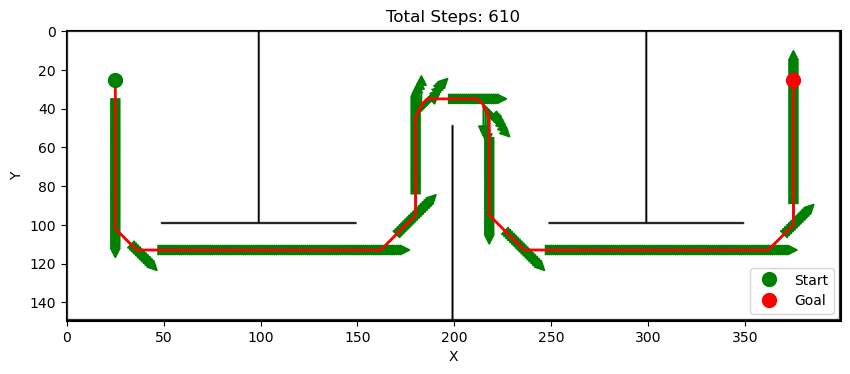

In [11]:
path = planner.path
path_x = [p[0] for p in path]
path_y = [p[1] for p in path]
path_theta = [p[2] for p in path]
map_display = 1 - map
plt.figure(figsize=(10, 8))
plt.imshow(map_display, cmap='gray', origin='upper')
plt.plot(path_x, path_y, 'r-', linewidth=2)

plt.plot(start[0], start[1], 'go', markersize=10, label='Start')
plt.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')
for x, y, theta in path:
    dx = np.cos(np.radians(theta)) * 10
    dy = np.sin(np.radians(theta)) * 10
    plt.arrow(x, y, dx, dy, head_width=5, head_length=5, fc='green', ec='green')
plt.title(f'Total Steps: {planner.total_steps}')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig('greedy.png')
plt.show()